# LAB4 - TensorFlow Lite


Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl


## Wprowadzenie

Celem zajęć jest analiza działania konwersji sieci neuronowych do postaci możliwej do uruchomienia na urządzeniach o ograniczonych zasobach. W czasie zajęć będzie wykorzystywany zbiór Fashion MNIST, który zawiera 60000 obrazków w 10 kategoriach:

https://github.com/zalandoresearch/fashion-mnist


https://www.tensorflow.org/datasets/catalog/fashion_mnist


### Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning



In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import pathlib

import time

print(tf.__version__)

2.2.0-rc2


Przygotuj zbiór testowy.

In [3]:
splits = ("train[:80%]", "train[:10%]", "train[:10%]")

splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print(num_examples)
print(num_classes)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteKAWQMG/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteKAWQMG/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.
60000
10


Wypisz ilość elementów w zbiorze uczącym , walidacyjnym i testowym.


In [4]:
print(train_examples)
print(validation_examples)
print(test_examples)

print(len(list(train_examples)))
print(len(list(validation_examples)))
print(len(list(test_examples)))



<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
48000
6000
6000


Zbiór fashion_mnist nie posiada słownych opisów klas.

In [0]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**TODO** Zmień poniższy kod tak by wyświetlić 10 przykładowych obrazków - po jednym z każdej klasy.

(28, 28, 1)
(28, 28)


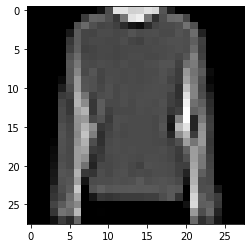

Pullover
(28, 28, 1)
(28, 28)


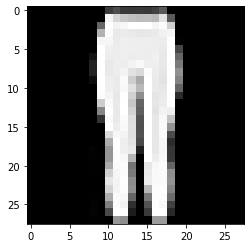

Trouser
(28, 28, 1)
(28, 28)


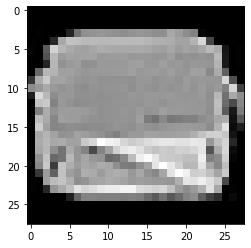

Bag
(28, 28, 1)
(28, 28)


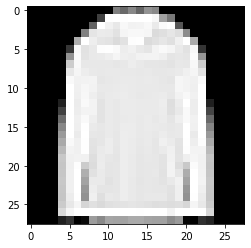

Coat
(28, 28, 1)
(28, 28)


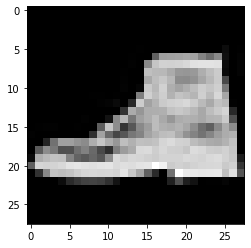

Ankle boot
(28, 28, 1)
(28, 28)


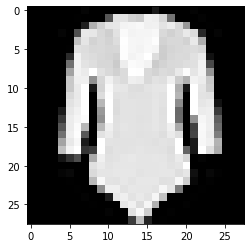

T-shirt_top
(28, 28, 1)
(28, 28)


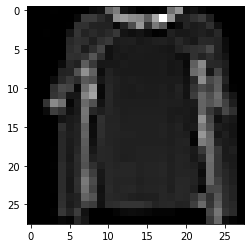

Shirt
(28, 28, 1)
(28, 28)


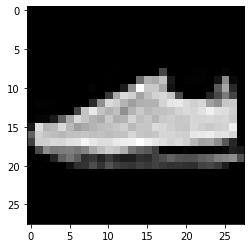

Sneaker
(28, 28, 1)
(28, 28)


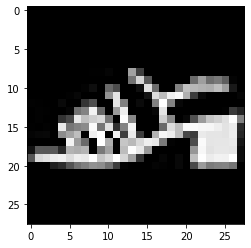

Sandal
(28, 28, 1)
(28, 28)


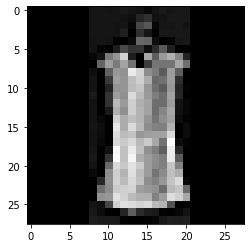

Dress


In [6]:
temp = [False for i in range(10)]
for example in train_examples:
    if temp[example[1].numpy()] == 0:
      print(example[0].numpy().shape)
      print(example[0].numpy().reshape(28,28).shape)
      plt.imshow(example[0].numpy().reshape(28,28), cmap=plt.cm.gray)
      plt.show()
      print(class_names[example[1].numpy()])
      temp[example[1].numpy()] = True
    else:
      if all(temp):
        break


Przygotowanie danych wejściowych do procesu uczenia.

In [0]:
IMG_SIZE = 28

In [0]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0
  return image, label

In [0]:
BATCH_SIZE = 32

In [0]:
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example).prefetch(1)
test_batches = test_examples.cache().batch(1).map(format_example)

In [11]:
print(train_batches)
print(validation_batches)
print(test_batches)

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
__________________________________________________

W celu skrócenia czasu uczenia sieci wskazane jest użycie GPU.

In [14]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.4542 - accuracy: 0.8371 - val_loss: 0.3310 - val_accuracy: 0.8805
Epoch 2/10
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3056 - accuracy: 0.8898 - val_loss: 0.2441 - val_accuracy: 0.9132
Epoch 3/10
1500/1500 [==============================] - 28s 18ms/step - loss: 0.2590 - accuracy: 0.9053 - val_loss: 0.2119 - val_accuracy: 0.9228
Epoch 4/10
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2235 - accuracy: 0.9192 - val_loss: 0.2028 - val_accuracy: 0.9263
Epoch 5/10
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1951 - accuracy: 0.9268 - val_loss: 0.1765 - val_accuracy: 0.9332
Epoch 6/10
1500/1500 [==============================] - 28s 18ms/step - loss: 0.1688 - accuracy: 0.9373 - val_loss: 0.1374 - val_accuracy: 0.9515
Epoch 7/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1479 - accuracy: 0.9456 - val_loss: 0.1332 -

# Zapisywanie NN

Szczegółowe informacje dotyczące zapisywania modeli TensorFlow dostępne pod linkiem:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [15]:
export_dir = 'saved_model'
model.save(export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". W katalogu "saved_model" znajduje się zapisany model.

# Export do TFLite

Narzędzie `TFLiteConverter` zostanie wykorzystane do konwersji modelu NN do formatu akceptowanego przez TFLite tzn. `flat protocol buffers`.

https://www.tensorflow.org/lite/guide/get_started#2_convert_the_model_format

Wygenerowany model `"model-base.tflite"` operuje na wagach typu `float32`.

In [0]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  tflite_model = converter.convert()

  with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". 

Kolejnym krokiem jest kwantyzacja wag modelu z 32 bitowych liczb rzeczywistych do liczb 8 bitowych. Proces kwantyzacji jest uruchamiany na gotowym, wyuczonym modelu. Należy wybrać profil optymaliacji `tf.lite.Optimize.DEFAULT`.



In [0]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  
  #TODO ustaw odpowiedni rodzaj optymalizacji sieci neuronowej
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  tflite_model = converter.convert()

  with open("model-quant.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

In [0]:
# funkcja testujaca model z wykorzystaniem interpretera TFLite
# TODO zmodyfikuj funkcje tak by zwracala (accuracy, latency)
import timeit
def test_model_accuracy(tflite_model):
  interpreter = tf.lite.Interpreter(model_path=tflite_model)
  interpreter.allocate_tensors()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  accuracy = 0
  amount = 0
  s = timeit.default_timer()
  for img, label in test_batches:
    amount += 1
    interpreter.set_tensor(input_index, img)

    interpreter.invoke()

    prediction = interpreter.get_tensor(output_index)
    label_is = np.argmax(prediction, axis=-1)[0]
    label_should_be = label[0].numpy()
    if label_is == label_should_be:
      accuracy += 1
    #print("Label is {} should be {}.".format(label_is, label_should_be))
  e = timeit.default_timer()
  return (accuracy/amount, (e - s)/amount) #(accuracy, latency)



In [37]:
#TODO tylko na potrzeby testowania - do usuniecia
base_accuracy_latency = test_model_accuracy("model-base.tflite")
print(base_accuracy_latency)
#TODO tylko na potrzeby testowania - do usuniecia
quant_accuracy_latency = test_model_accuracy("model-quant.tflite")
print(quant_accuracy_latency)


(0.9706666666666667, 0.0007572489340000175)
(0.9701666666666666, 0.0007085275063333257)


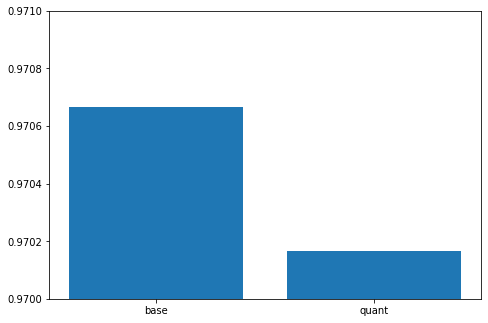

In [43]:
# porównaj dokladnosc wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model = ['base', 'quant']
accuracy = [base_accuracy_latency[0], quant_accuracy_latency[0]]
plt.ylim(bottom=0.97)
plt.ylim(top=0.971)
ax.bar(model, accuracy)
plt.show()

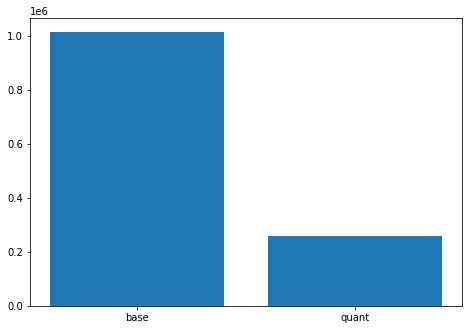

In [51]:
# porównaj rozmiar wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
from pathlib import Path
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model = ['base', 'quant']
accuracy = [Path('model-base.tflite').stat().st_size, Path('model-quant.tflite').stat().st_size]
ax.bar(model, accuracy)
plt.show()

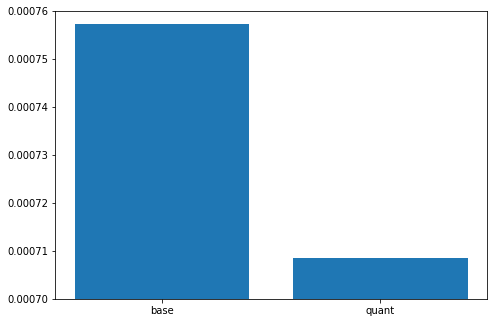

In [52]:
# porównaj czas dzialania wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model = ['base', 'quant']
accuracy = [base_accuracy_latency[1], quant_accuracy_latency[1]]
plt.ylim(bottom=0.0007)
plt.ylim(top=0.00076)
ax.bar(model, accuracy)
plt.show()

 # Wnioski

Możemy zauważyć bardzo dobre wyniki, moim zdaniem. Dla zoptymizowanego modelu accuracy jest gorsza o 0.02%, różnica w rożmiarze jest duża, czas działania też jest troche mniejszy. 
Co spełnia postawiony cel: mniejszy rozmiar dzięki małym staram dokładności, czas wykonania nie pogorszył się.